In [1]:
import numpy as np
import pandas as pd
import string
PUNCT_TO_REMOVE = string.punctuation

from nltk import word_tokenize
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words("english"))

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer

#读邮件数据CSV
train = pd.read_csv("C:/Users/Administrator/Desktop/work1/data/train.csv", encoding='Windows-1252')
train_email = pd.read_csv("C:/Users/Administrator/Desktop/work1/data/train.csv", usecols=[2], encoding='Windows-1252')
train_label = pd.read_csv("C:/Users/Administrator/Desktop/work1/data/train.csv", usecols=[1], encoding='Windows-1252')



In [2]:
#数据预处理
def text_processing(text):
    text = text.lower()
    text = re.compile(r'https?://\S+|www\.\S+').sub(r'', text)
    text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])
    text = " ".join([stemmer.stem(word) for word in text.split()])
    return text

train_email['Email'] = train_email['Email'].apply(text_processing)


                       Email
count                   4458
unique                  4137
top     sorri ill call later
freq                      25
       Label
count   4458
unique     2
top      ham
freq    3866


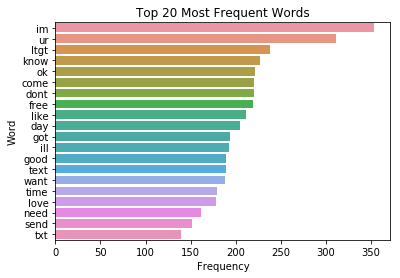

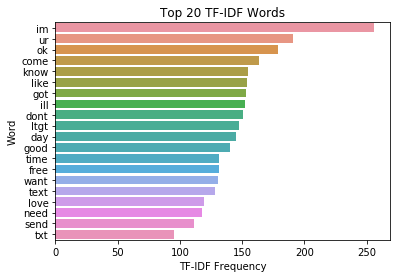

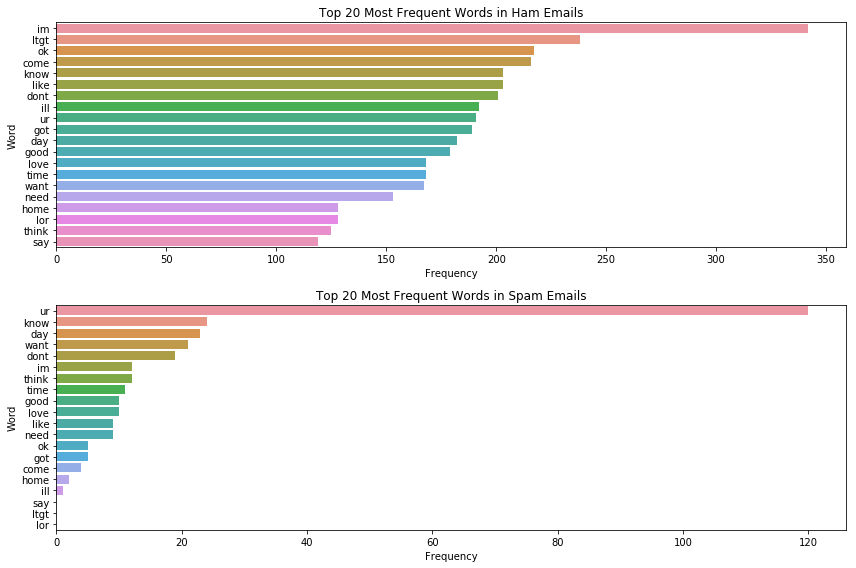

D:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


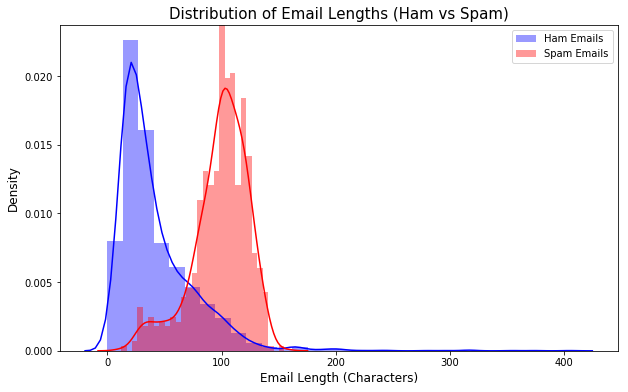

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 复制原始的 train_email DataFrame
train_email_copy = train_email.copy()

# 将标签列合并到新的 DataFrame
train_email_copy['Label'] = train_label

# 检查数据的基本统计信息
print(train_email.describe())
print(train_label.describe())

# 词频统计
vectorizer = CountVectorizer(stop_words='english', max_features=20)  # 除去常见的停用词
X = vectorizer.fit_transform(train_email['Email'])

# 获取词频
word_freq = dict(zip(vectorizer.get_feature_names(), X.sum(axis=0).tolist()[0]))

# 可视化词频
top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

# 绘制词频条形图
sns.barplot(x='Frequency', y='Word', data=top_words_df)
plt.title('Top 20 Most Frequent Words')
plt.savefig('总词频.png', dpi=600)
plt.show()

# 使用TF-IDF提取特征
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=20)
X_tfidf = tfidf_vectorizer.fit_transform(train_email['Email'])

# 获取TF-IDF词频
tfidf_word_freq = dict(zip(tfidf_vectorizer.get_feature_names(), X_tfidf.sum(axis=0).tolist()[0]))

# 可视化TF-IDF词频
top_tfidf_words = sorted(tfidf_word_freq.items(), key=lambda x: x[1], reverse=True)[:20]
top_tfidf_words_df = pd.DataFrame(top_tfidf_words, columns=['Word', 'TF-IDF Frequency'])

sns.barplot(x='TF-IDF Frequency', y='Word', data=top_tfidf_words_df)
plt.title('Top 20 TF-IDF Words')
plt.savefig('TF-IDF词频.png', dpi=600)
plt.show()

# 分类词频统计
# 将ham和spam分类
ham_emails = train_email_copy[train_email_copy['Label'] == 'ham']['Email']
spam_emails = train_email_copy[train_email_copy['Label'] == 'spam']['Email']

# 创建CountVectorizer实例
vectorizer = CountVectorizer(stop_words='english', max_features=20)

# 对ham和spam邮件分别进行词频统计
ham_word_freq = vectorizer.fit_transform(ham_emails)
spam_word_freq = vectorizer.transform(spam_emails)

# 获取词频
ham_word_freq_dict = dict(zip(vectorizer.get_feature_names(), ham_word_freq.sum(axis=0).tolist()[0]))
spam_word_freq_dict = dict(zip(vectorizer.get_feature_names(), spam_word_freq.sum(axis=0).tolist()[0]))

# 转换为DataFrame方便绘制
ham_words_df = pd.DataFrame(list(ham_word_freq_dict.items()), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).head(20)
spam_words_df = pd.DataFrame(list(spam_word_freq_dict.items()), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).head(20)

# 绘制词频分布图
plt.figure(figsize=(12, 8))

# 绘制ham的词频
plt.subplot(2, 1, 1)
sns.barplot(x='Frequency', y='Word', data=ham_words_df)
plt.title('Top 20 Most Frequent Words in Ham Emails')

# 绘制spam的词频
plt.subplot(2, 1, 2)
sns.barplot(x='Frequency', y='Word', data=spam_words_df)
plt.title('Top 20 Most Frequent Words in Spam Emails')

plt.tight_layout()
plt.savefig('ham和spam词频.png', dpi=600)
plt.show()

# 邮件长度
# 计算邮件长度（字符数）
train_email_copy['Length'] = train_email_copy['Email'].apply(len)

# 分别提取ham和spam邮件的长度
ham_length = train_email_copy[train_email_copy['Label'] == 'ham']['Length']
spam_length = train_email_copy[train_email_copy['Label'] == 'spam']['Length']

# 绘制邮件长度的分布图
plt.figure(figsize=(10, 6))

# 绘制ham邮件的字符数分布
sns.distplot(ham_length, kde=True, color='blue', label='Ham Emails', bins=30)

# 绘制spam邮件的字符数分布
sns.distplot(spam_length, kde=True, color='red', label='Spam Emails', bins=30)

# 添加标题和标签
plt.title('Distribution of Email Lengths (Ham vs Spam)', fontsize=15)
plt.xlabel('Email Length (Characters)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.savefig('邮件长度.png', dpi=600)
plt.show()
